# Informer VS LSTM stock forcating (technical analysis)

## Download code and dataset

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/UP3M/Predicting-Stock-Market-Closing-Prices-Informer-vs-LSTM
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 576 (delta 199), reused 188 (delta 188), pack-reused 354
Receiving objects: 100% (576/576), 6.48 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Informer2020  sample_data  sentimentAllNews.csv  stock_price.csv


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
# !pip install -r ./Informer2020/requirements.txt

### Modification on exp_informer.py (to fit with the reseach)

In [4]:
# Replace the content of exp_informer.py with new setting
new_content = """
from data.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from exp.exp_basic import Exp_Basic
from models.model import Informer, InformerStack

from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric

import numpy as np

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import os
import time

import warnings
warnings.filterwarnings('ignore')

class Exp_Informer(Exp_Basic):
    def __init__(self, args):
        super(Exp_Informer, self).__init__(args)

    def _build_model(self):
        model_dict = {
            'informer':Informer,
            'informerstack':InformerStack,
        }
        if self.args.model=='informer' or self.args.model=='informerstack':
            e_layers = self.args.e_layers if self.args.model=='informer' else self.args.s_layers
            model = model_dict[self.args.model](
                self.args.enc_in,
                self.args.dec_in,
                self.args.c_out,
                self.args.seq_len,
                self.args.label_len,
                self.args.pred_len,
                self.args.factor,
                self.args.d_model,
                self.args.n_heads,
                e_layers, # self.args.e_layers,
                self.args.d_layers,
                self.args.d_ff,
                self.args.dropout,
                self.args.attn,
                self.args.embed,
                self.args.freq,
                self.args.activation,
                self.args.output_attention,
                self.args.distil,
                self.args.mix,
                self.device
            ).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        args = self.args

        data_dict = {
            'ETTh1':Dataset_ETT_hour,
            'ETTh2':Dataset_ETT_hour,
            'ETTm1':Dataset_ETT_minute,
            'ETTm2':Dataset_ETT_minute,
            'WTH':Dataset_Custom,
            'ECL':Dataset_Custom,
            'Solar':Dataset_Custom,
            'custom':Dataset_Custom,
        }
        Data = data_dict[self.args.data]
        timeenc = 0 if args.embed!='timeF' else 1

        if flag == 'test':
            shuffle_flag = False; drop_last = True; batch_size = args.batch_size; freq=args.freq
        elif flag=='pred':
            shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.detail_freq
            Data = Dataset_Pred
        else:
            shuffle_flag = True; drop_last = True; batch_size = args.batch_size; freq=args.freq
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            inverse=args.inverse,
            timeenc=timeenc,
            freq=freq,
            cols=args.cols
        )
        print(flag, len(data_set))
        # Save the training data before shuffling
        if flag == 'train':
            data_loader1 = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last)

            data_loader2 = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=drop_last)
            return data_set, data_loader1, data_loader2

        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last)

        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion =  nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        self.model.eval()
        total_loss = []
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(vali_loader):
            pred, true = self._process_one_batch(
                vali_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            loss = criterion(pred.detach().cpu(), true.detach().cpu())
            total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting, f):
        train_data, train_loader, train_loader2 = self._get_data(flag = 'train')
        vali_data, vali_loader = self._get_data(flag = 'val')
        test_data, test_loader = self._get_data(flag = 'test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion =  self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []
            self.model.train()
            epoch_time = time.time()
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                iter_count += 1

                model_optim.zero_grad()
                pred, true = self._process_one_batch(
                    train_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                loss = criterion(pred, true)
                train_loss.append(loss.item())

                if (i+1) % 100==0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time()-time_now)/iter_count
                    left_time = speed*((self.args.train_epochs - epoch)*train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch+1, self.args)

        # result save
        traindata = []
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader2):
            pred, true = self._process_one_batch(
                train_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            traindata.append(true.detach().cpu().numpy())
        traindata = np.array(traindata)
        traindata = traindata.reshape(-1, traindata.shape[-2], traindata.shape[-1])

        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        np.save(folder_path+'traindata.npy', traindata)
        return self.model

    def test(self, setting):
        test_data, test_loader = self._get_data(flag='test')

        self.model.eval()

        preds = []
        trues = []

        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            pred, true = self._process_one_batch(
                test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())
            trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))

        np.save(folder_path+'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+'pred.npy', preds)
        np.save(folder_path+'true.npy', trues)

        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path+'/'+'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        self.model.eval()

        preds = []

        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
            pred, true = self._process_one_batch(
                pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

        # result save
        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path+'real_prediction.npy', preds)

        return

    def _process_one_batch(self, dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        batch_x = batch_x.float().to(self.device)
        batch_y = batch_y.float()

        batch_x_mark = batch_x_mark.float().to(self.device)
        batch_y_mark = batch_y_mark.float().to(self.device)

        # decoder input
        if self.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        elif self.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:self.args.label_len,:], dec_inp], dim=1).float().to(self.device)
        # encoder - decoder
        if self.args.use_amp:
            with torch.cuda.amp.autocast():
                if self.args.output_attention:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if self.args.output_attention:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if self.args.inverse:
            outputs = dataset_object.inverse_transform(outputs)
        f_dim = -1 if self.args.features=='MS' else 0
        batch_y = batch_y[:,-self.args.pred_len:,f_dim:].to(self.device)

        return outputs, batch_y
"""

file_path = '/content/Informer2020/exp/exp_informer.py'
with open(file_path, 'w') as file:
    file.write(new_content)

### Load Dataset

In [5]:
import pandas as pd

# Read the CSV files into pandas dataframes
df = pd.read_csv('/content/Predicting-Stock-Market-Closing-Prices-Informer-vs-LSTM/Data/stock_price.csv')

# Convert the date columns to datetime objects with the appropriate format
df['date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d %H:%M:%S')

# List of columns to keep
columns_to_keep = ["date", "Close"]

# Filter the DataFrame to keep only the specified columns
df_filtered = df[columns_to_keep]
df_filtered.head(10)

,date,Close
0,2018-12-03 00:00:00,2790.370117
1,2018-12-04 00:00:00,2700.060059
2,2018-12-06 00:00:00,2695.949951
3,2018-12-07 00:00:00,2633.080078
4,2018-12-10 00:00:00,2637.719971
5,2018-12-11 00:00:00,2636.780029
6,2018-12-12 00:00:00,2651.070068
7,2018-12-13 00:00:00,2650.540039
8,2018-12-14 00:00:00,2599.949951
9,2018-12-17 00:00:00,2545.939941


## Apply Technical Analysis (TA)

In [6]:
!pip install stockstats

In [7]:
from stockstats import wrap, unwrap
df = wrap(df_filtered)
df_filtered['rsi'] = df['rsi']
df_filtered['macd'] = df['macd']
df_filtered = unwrap(df_filtered)
df_filtered = df_filtered.fillna(0)
df_filtered.head(10)

<ipython-input-7-38311e2b5dec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rsi'] = df['rsi']
<ipython-input-7-38311e2b5dec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['macd'] = df['macd']


,close,rsi,macd,macds,macdh
date,,,,,
2018-12-03 00:00:00,2790.370117,0.000000,0.000000,0.000000,0.000000
2018-12-04 00:00:00,2700.060059,0.000000,-2.026187,-1.125660,-0.900528
2018-12-06 00:00:00,2695.949951,0.000000,-2.709219,-1.774659,-0.934560
2018-12-07 00:00:00,2633.080078,0.000000,-5.223372,-2.942922,-2.280449
2018-12-10 00:00:00,2637.719971,3.341171,-6.294928,-3.940068,-2.354860
2018-12-11 00:00:00,2636.780029,3.316993,-6.860947,-4.731789,-2.129158
2018-12-12 00:00:00,2651.070068,13.558453,-6.458400,-5.168748,-1.289652
2018-12-13 00:00:00,2650.540039,13.501326,-6.109846,-5.394912,-0.714934
2018-12-14 00:00:00,2599.949951,9.421121,-8.285473,-6.062646,-2.222828


## Experiments: Train and Test

In [8]:
import pandas as pd
import os
from sklearn.model_selection import TimeSeriesSplit

# Set the number of splits (folds)
n_splits = 10

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create a list to store the folds
folds = []
i = 0
for train_index, test_index in tscv.split(df_filtered):
    # Extract DataFrames for the current fold
    train_fold = df_filtered.iloc[train_index].copy()
    test_fold = df_filtered.iloc[test_index].copy()

    # Combine train and test DataFrames into a single DataFrame for the current fold
    combined_fold = pd.concat([train_fold, test_fold])

    #save the data
    if not os.path.exists("/content/fold"):
      os.makedirs("/content/fold")
    combined_fold.to_csv('fold/preprocessed_dataset_{}.csv'.format(i), index=True)

    i += 1


In [10]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '/content/' # root path of data file
args.data_path = 'preprocessed_dataset.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'close' # target feature in S or MS task
args.freq = 'd' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 10 # input sequence length of Informer encoder
args.label_len = 5 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'd'

args.batch_size = 24
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 100
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [12]:
!rm -r /content/results

rm: cannot remove '/content/results': No such file or directory


In [13]:
for _ in range (i):
  # Set augments by using data name and adjust the encoder decoder size (for MS), based on features
  data_parser = {
      'custom':{'data':'fold/preprocessed_dataset_{}.csv'.format(_),'T':'close','M':[3,3,3],'S':[1,1,1],'MS':[3,3,1]},
  }
  if args.data in data_parser.keys():
      data_info = data_parser[args.data]
      args.data_path = data_info['data']
      args.target = data_info['T']
      args.enc_in, args.dec_in, args.c_out = data_info[args.features]
      args.detail_freq = args.freq
  args.freq = args.freq[-1:]
  print('Args in experiment:')
  print(args)
  Exp = Exp_Informer
  for ii in range(args.itr):
      # setting record of experiments
      setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}_fold{}'.format(args.model, args.data, args.features,
                  args.seq_len, args.label_len, args.pred_len,
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii, _)

      # set experiments
      exp = Exp(args)

      # train
      print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
      exp.train(setting,_)

      # test
      print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
      exp.test(setting)

      torch.cuda.empty_cache()

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': '/content/', 'data_path': 'fold/preprocessed_dataset_0.csv', 'features': 'M', 'target': 'close', 'freq': 'd', 'checkpoints': './informer_checkpoints', 'seq_len': 10, 'label_len': 5, 'pred_len': 1, 'enc_in': 5, 'dec_in': 5, 'c_out': 5, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 24, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 100, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'd'}
Use CPU
>>>>>>>start training : informer_custom_ftM_sl10_ll5_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0_fold0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 151
val 24
test 46
Epoch: 1 c

## LSTM model as comparison

In [14]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from utils.metrics import metric

# Define sequence length
seq_len = 10

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])  # Contains feature
        y.append(data[i, 0])  # Close price is the target variable
    return np.array(X), np.array(y)


for i in range(10):
    folder_path = os.path.join('./results/'+setting[:-1]+"{}".format(i))
    # Check if the folder exists
    if os.path.exists(folder_path):
        traindata = np.load(folder_path+'/traindata.npy')
        flipped_array = np.flip(traindata[:,0], axis=1)
        X_train, y_train = create_sequences(flipped_array, seq_len)
        # Building the LSTM Model
        model = Sequential()
        model.add(LSTM(units=70, activation="tanh", return_sequences=True, input_shape=(seq_len, X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(units=30, activation="tanh", return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=10, activation="tanh"))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation="linear"))

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model with early stopping
        history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.1, callbacks=[early_stopping])

        # testing
        testdata = np.load(folder_path+'/true.npy')
        test_flipped_array = np.flip(testdata[:,0], axis=1)
        X_test_new, y_test_new = create_sequences(test_flipped_array, seq_len)

        # Make predictions on the test set and inverse scale for true value comparison
        predictions = model.predict(X_test_new)

        # Calculate evaluation Metrics
        mae, mse, rmse, mape, mspe = metric(y_test_new, predictions)
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'MAPE: {mape * 100:.2f}%')
        np.save(folder_path+'/metrics_lstm.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+'/pred_lstm.npy', predictions)

    else:
        print(f'Folder {folder_path} does not exist.')


Epoch 1/100
6/6 [==============================] - 6s 321ms/step - loss: 0.4478 - val_loss: 1.2001
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.2814 - val_loss: 0.9056
Epoch 3/100
6/6 [==============================] - 0s 31ms/step - loss: 0.1713 - val_loss: 0.5503
Epoch 4/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1170 - val_loss: 0.2829
Epoch 5/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1019 - val_loss: 0.1979
Epoch 6/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0808 - val_loss: 0.1565
Epoch 7/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0747 - val_loss: 0.1334
Epoch 8/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0724 - val_loss: 0.1329
Epoch 9/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0721 - val_loss: 0.1510
Epoch 10/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0724 - val_loss: 0.1639
Epoch 11/100
6/6 [

4/4 [==============================] - 1s 7ms/step
MSE: 8.203627586364746
MAE: 2.796285629272461
MAPE: 160.81%
Epoch 1/100
25/25 [==============================] - 7s 64ms/step - loss: 0.2829 - val_loss: 0.5922
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0764 - val_loss: 0.5630
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0633 - val_loss: 0.4325
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0586 - val_loss: 0.4232
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0492 - val_loss: 0.3895
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0586 - val_loss: 0.2422
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0612 - val_loss: 0.2864
Epoch 8/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0540 - val_loss: 0.1964
Epoch 9/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0517 - val_lo

5/5 [==============================] - 1s 5ms/step
MSE: 2.5282366275787354
MAE: 1.5429997444152832
MAPE: 62.29%
Epoch 1/100
28/28 [==============================] - 7s 59ms/step - loss: 0.2198 - val_loss: 0.1732
Epoch 2/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0602 - val_loss: 0.3014
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0457 - val_loss: 0.2277
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0425 - val_loss: 0.2577
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0346 - val_loss: 0.1408
Epoch 6/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.2433
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.1379
Epoch 8/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0420 - val_loss: 0.1159
Epoch 9/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0387 - val_l

### Result and Visualization

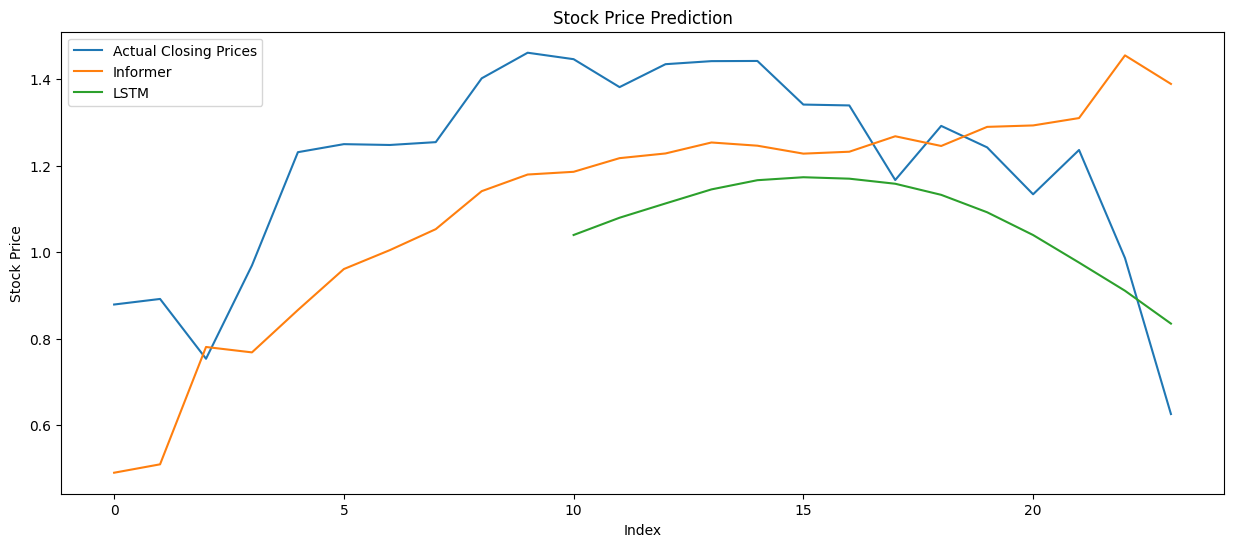

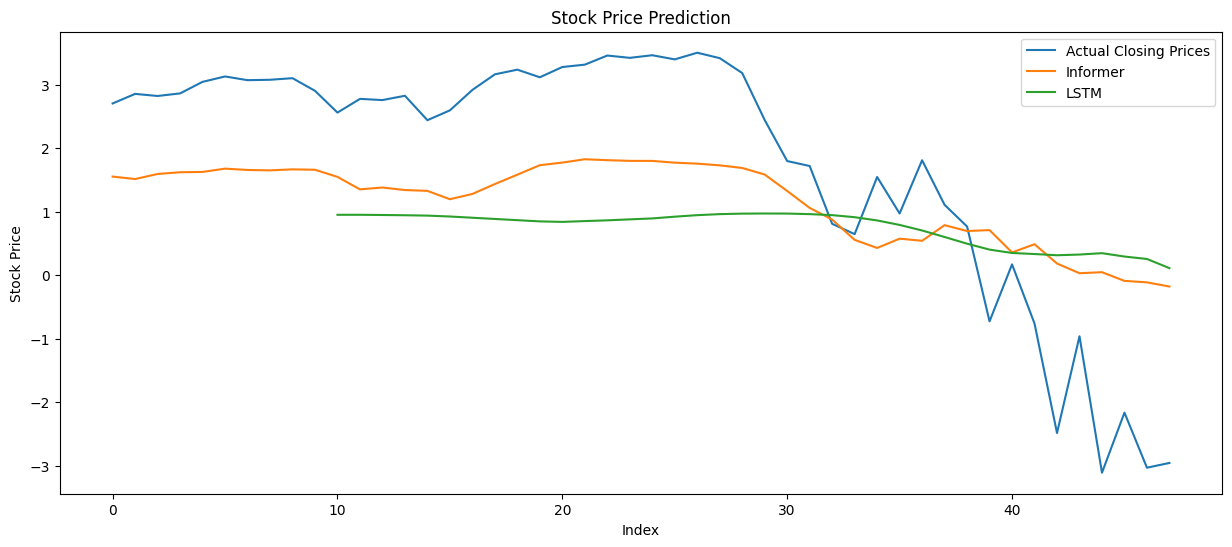

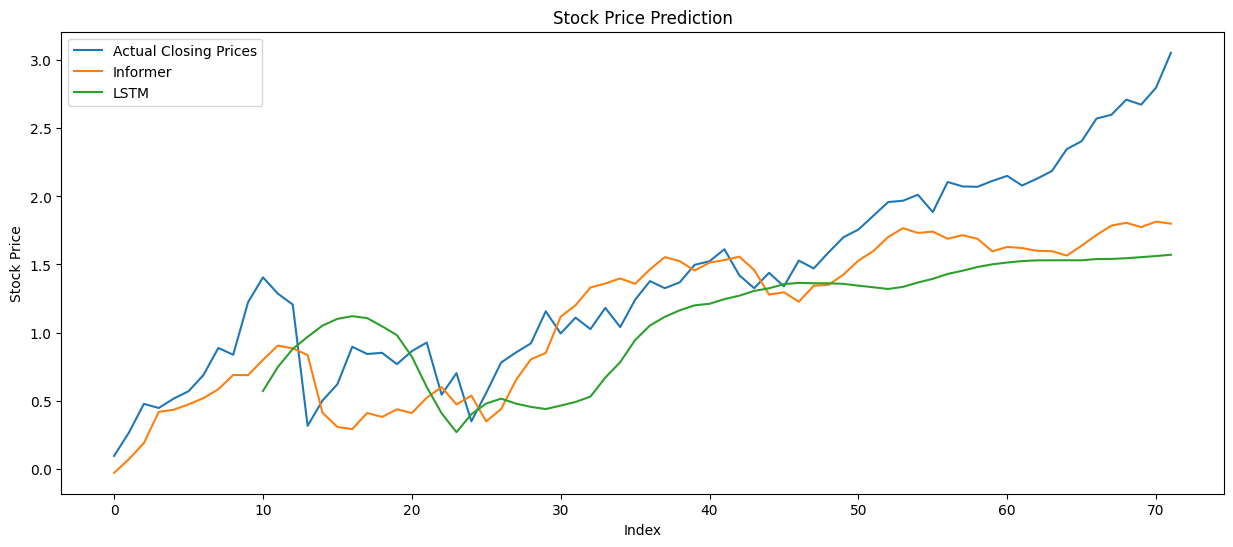

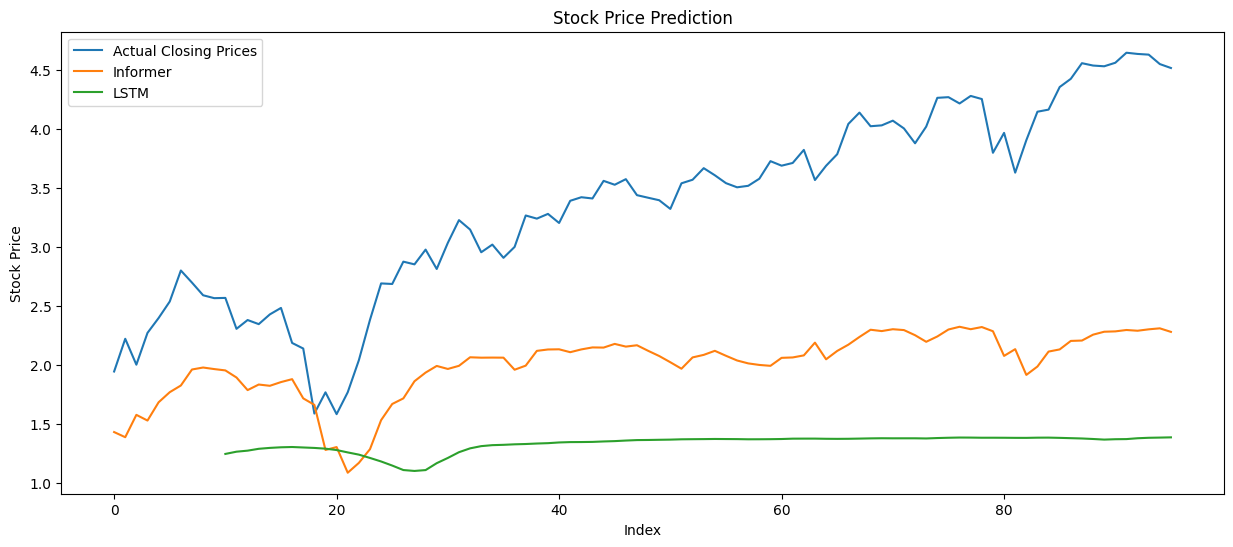

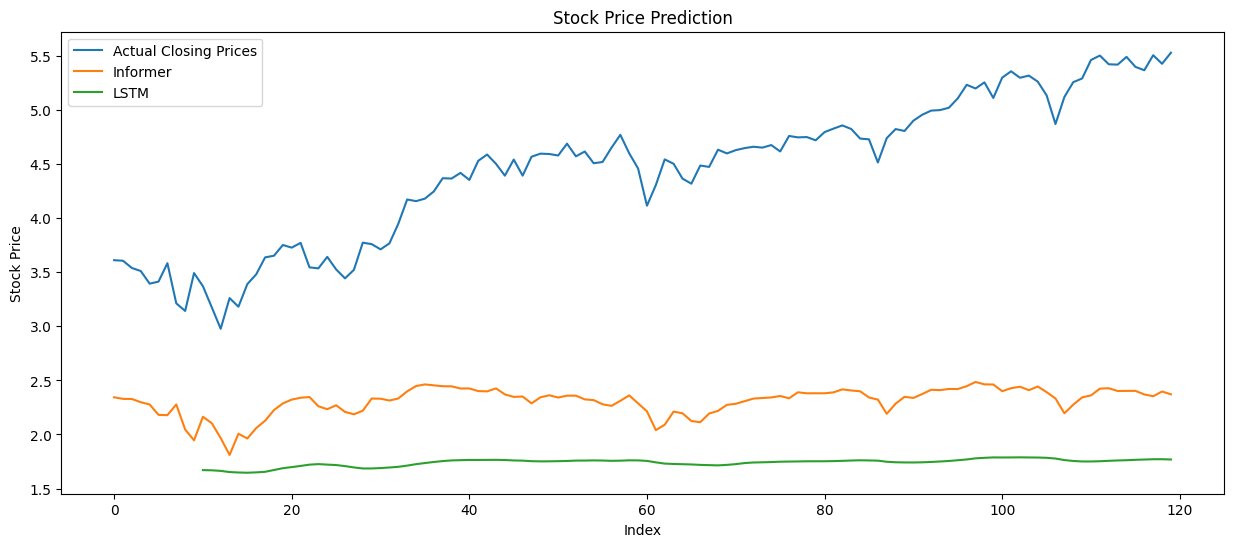

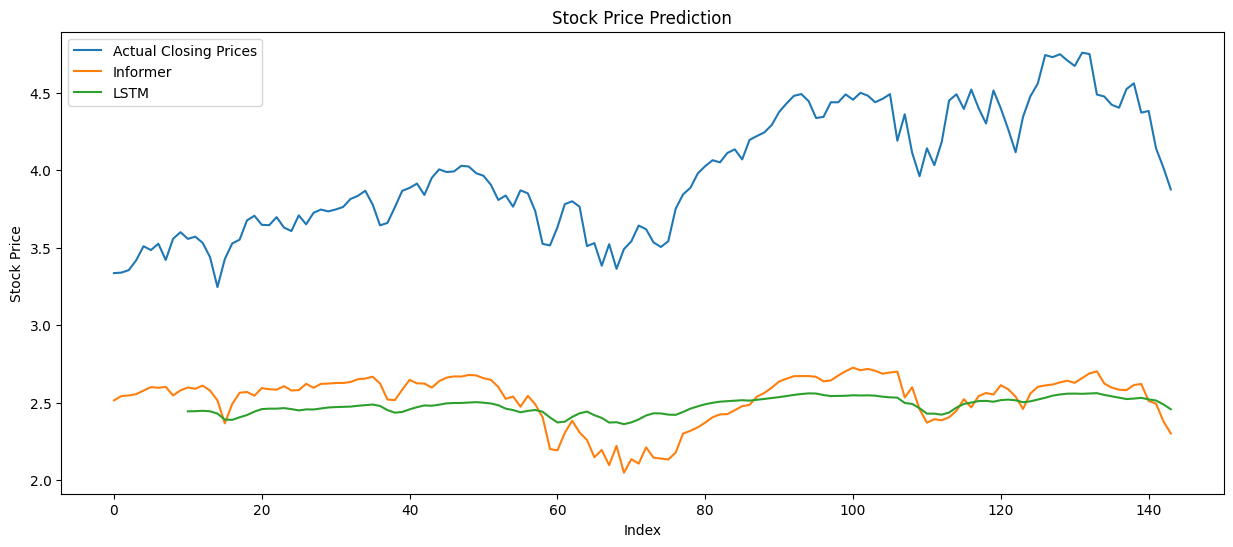

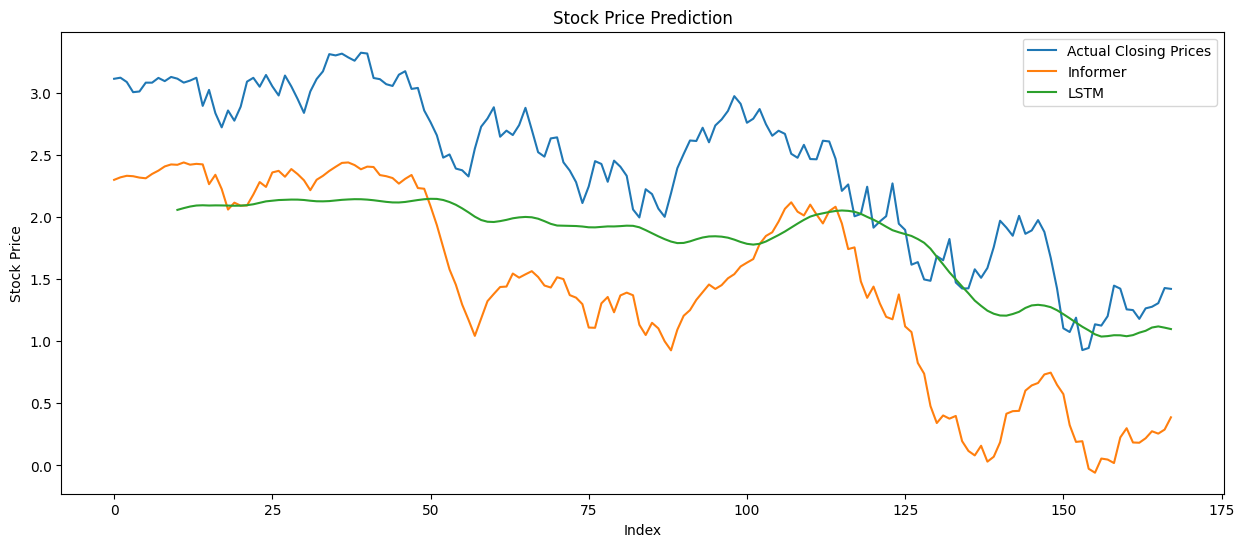

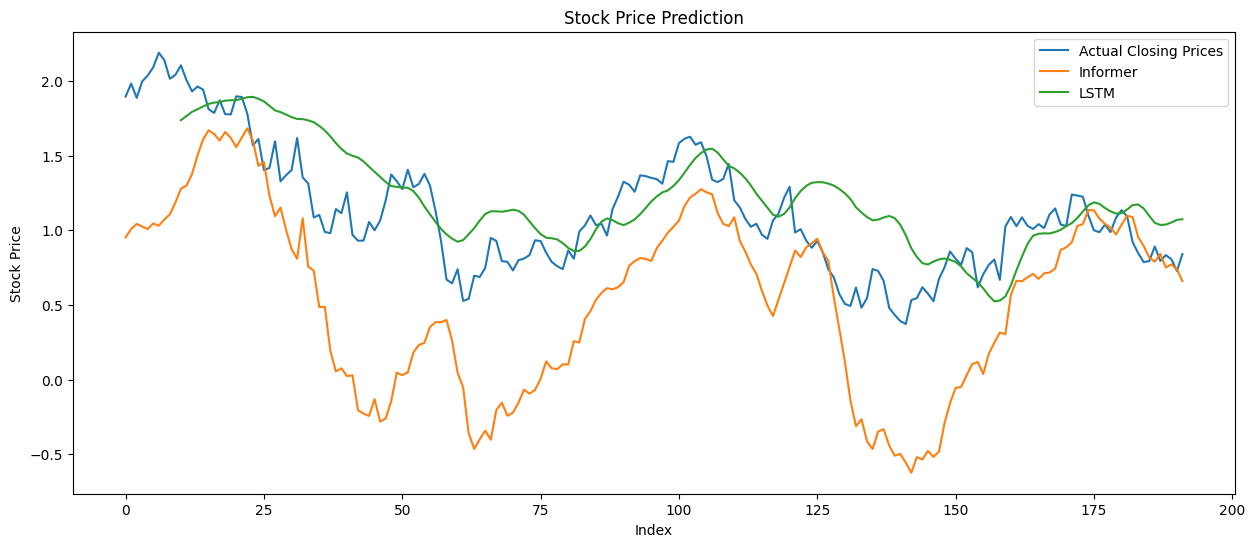

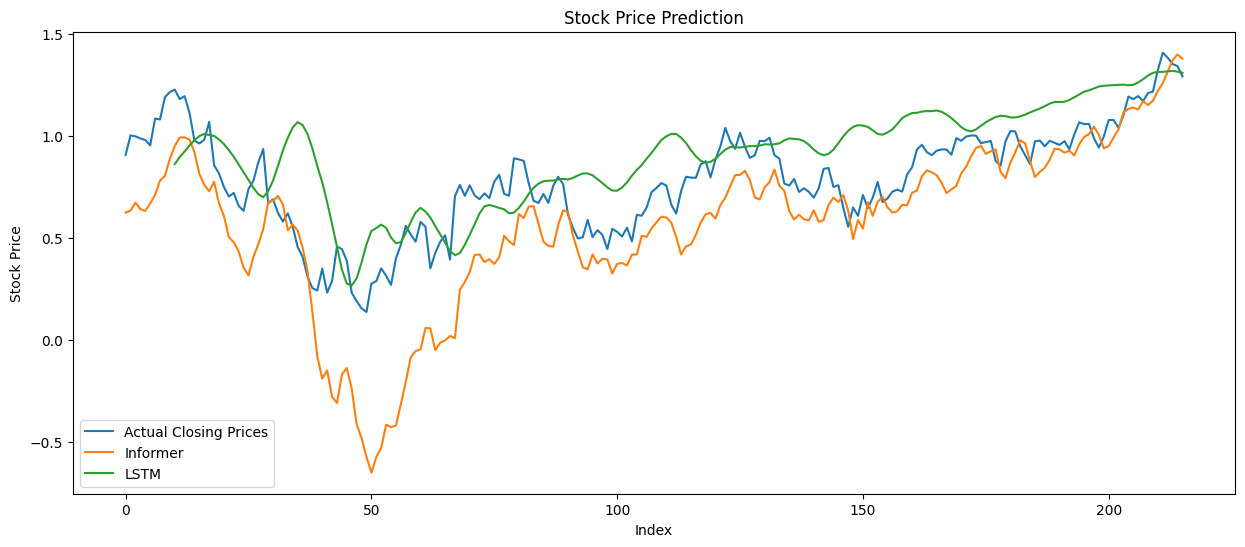

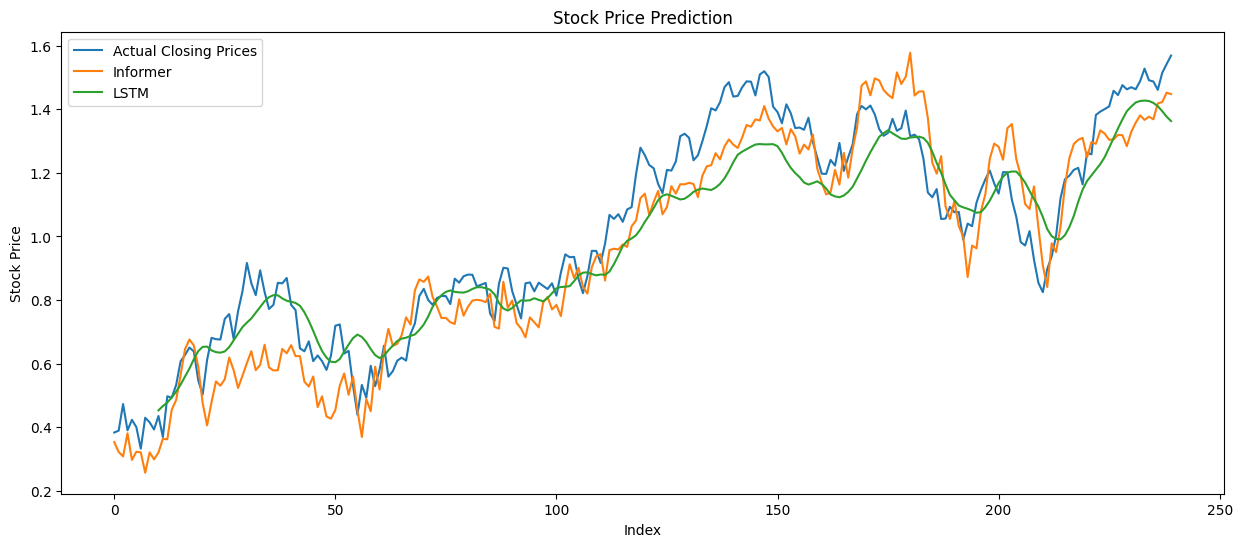

In [16]:
for i in range(10):
    folder_path = os.path.join('./results/'+setting[:-1]+"{}".format(i))
    # Check if the folder exists
    if os.path.exists(folder_path):
        g_truth = np.load(folder_path+'/true.npy')
        pred_informer = np.load(folder_path+'/pred.npy')
        pred_lstm = np.load(folder_path+'/pred_lstm.npy')
        x_values = np.arange(len(pred_lstm)) + 10

        plt.figure(figsize=(15, 6))
        plt.plot(g_truth[:,:,2], label='Actual Closing Prices')
        plt.plot(pred_informer[:,:,2], label='Informer')
        plt.plot(x_values, pred_lstm[:, 0], label='LSTM')
        plt.title('Stock Price Prediction')
        plt.xlabel('Index')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [17]:
mae = []
mse = []
rmse = []
mape = []
mspe = []

mael = []
msel = []
rmsel = []
mapel = []
mspel = []

for i in range(10):
    folder_path = os.path.join('./results/'+setting[:-1]+"{}".format(i))
    # Check if the folder exists
    if os.path.exists(folder_path):
        inf_m = np.load(folder_path+'/metrics.npy')
        l_m = np.load(folder_path+'/metrics_lstm.npy')
        mse.append(inf_m[1])
        rmse.append(inf_m[2])
        mape.append(inf_m[3])
        mspel.append(inf_m[4])
        mae.append(inf_m[0])

        msel.append(l_m[1])
        rmsel.append(l_m[2])
        mapel.append(l_m[3])
        mspel.append(l_m[4])
        mael.append(l_m[0])

# Calculate the standard deviation of MSE across folds
std_mse_inf = np.std(mse)
mean_mse_inf = np.mean(mse)
print("mean MSE Informer:", mean_mse_inf)
print("std MSE Informer: ", std_mse_inf)

# Calculate the standard deviation of MSE across folds
std_mse_lstm = np.std(msel)
mean_mse_lstm = np.mean(msel)
print("mean MSE LSTM:", mean_mse_lstm)
print("std MSE LSTM: ", std_mse_lstm)

mean MSE Informer: 0.84449357
std MSE Informer:  1.4791416
mean MSE LSTM: 2.2954578
std MSE LSTM:  2.6897244


In [19]:
# Calculate the standard deviation of MAE across folds
std_mae_inf = np.std(mae)
mean_mae_inf = np.mean(mae)
print("mean MAE Informer:", mean_mae_inf)
print("std MAE Informer: ", std_mae_inf)

# Calculate the standard deviation of MAE across folds
std_mae_lstm = np.std(mael)
mean_mae_lstm = np.mean(mael)
print("mean MAE LSTM:", mean_mae_lstm)
print("std MAE LSTM: ", std_mae_lstm)

mean MAE Informer: 0.4622651
std MAE Informer:  0.3401157
mean MAE LSTM: 1.1163671
std MAE LSTM:  0.8691392


In [20]:
# Calculate the standard deviation of MAPE across folds
std_mape_inf = np.std(mape)
mean_mape_inf = np.mean(mape)
print("mean MAPE Informer:", mean_mape_inf)
print("std MAPE Informer: ", std_mape_inf)

# Calculate the standard deviation of MAPE across folds
std_mape_lstm = np.std(mapel)
mean_mape_lstm = np.mean(mapel)
print("mean MAPE LSTM:", mean_mape_lstm)
print("std MAPE LSTM: ", std_mape_lstm)

mean MAPE Informer: 1.1761223
std MAPE Informer:  0.4917884
mean MAPE LSTM: 1.0146409
std MAPE LSTM:  0.989773


In [21]:
# Calculate the standard deviation of RMSE across folds
std_rmse_inf = np.std(rmse)
mean_rmse_inf = np.mean(rmse)
print("mean RMSE Informer:", mean_rmse_inf)
print("std RMSE Informer: ", std_rmse_inf)

# Calculate the standard deviation of RMSE across folds
std_rmse_lstm = np.std(rmsel)
mean_rmse_lstm = np.mean(rmsel)
print("mean RMSE LSTM:", mean_rmse_lstm)
print("std RMSE LSTM: ", std_rmse_lstm)

mean RMSE Informer: 0.7127292
std RMSE Informer:  0.5800954
mean RMSE LSTM: 1.2282879
std RMSE LSTM:  0.88699865


## Rescale the Result

In [ ]:
from sklearn.preprocessing import StandardScaler

for i in range(10):
    folder_path = os.path.join('./results/'+setting[:-1]+"{}".format(i))
    # Check if the folder exists
    if os.path.exists(folder_path):
        g_truth = np.load(folder_path+'/true.npy')
        pred_informer = np.load(folder_path+'/pred.npy')
        pred_lstm = np.load(folder_path+'/pred_lstm.npy')

        # Load the CSV file into a DataFrame
        data_ori = pd.read_csv("/content/fold/preprocessed_dataset_{}".format(i)+".csv")

        # Extract a specific column into an array
        close_price = data_ori["close"].values

        # Reshape the array if it's 1D (required by StandardScaler)
        close_price = close_price.reshape(-1, 1)

        # Initialize a StandardScaler object and fit it to the column data
        scaler = StandardScaler()
        scaler.fit(close_price)
        g_truth = scaler.inverse_transform(g_truth[:,:,2])
        pred_informer = scaler.inverse_transform(pred_informer[:,:,2])
        pred_lstm = scaler.inverse_transform(pred_lstm)

        maeL, mseL, rmseL, mapeL, mspeL = metric(pred_lstm, g_truth[10:])
        mae, mse, rmse, mape, mspe = metric(pred_informer, g_truth)
        x_values = np.arange(len(pred_lstm)) + 10

        print("LSTM-> MAE:", maeL, "MSE: ", mseL, "RMSE: ", rmseL, "MAPE: ", mapeL,"MSPE: ", mspeL)
        print("Informer-> MAE:", mae, "MSE: ", mse, "RMSE: ", rmse, "MAPE: ", mape,"MSPE: ", mspe)
        np.save(folder_path+'/inv_metrics_inf.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+'/inv_metrics_lstm.npy', np.array([maeL, mseL, rmseL, mapeL, mspeL]))


        plt.figure(figsize=(15, 6))
        plt.plot(g_truth[:,:], label='Actual Closing Prices')
        plt.plot(pred_informer[:,:], label='Informer')
        plt.plot(x_values, pred_lstm[:, 0], label='LSTM')
        plt.title('Stock Price Prediction')
        plt.xlabel('Index')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
